In [1]:
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np

#os.chdir("/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl")
os.chdir("/home/nicolas/codeRepo/OceanPlatformControl")
from ocean_navigation_simulator.controllers.multi_agent_planner import (
   MultiAgentPlanner,
)
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.Platform import PlatformState, PlatformStateSet
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.utils import units

In [2]:
# Initialize the Arena (holds all data sources and the platform, everything except controller)
arena = ArenaFactory.create(scenario_name="gulf_of_mexico_HYCOM_hindcast_local")

# Initialize two platforms
x_0 = PlatformState(
    lon=units.Distance(deg=-82.5),
    lat=units.Distance(deg=23.7),
    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc),
)
x_1 = PlatformState(
    lon=units.Distance(deg=-82.25),
    lat=units.Distance(deg=23.7),
    date_time=datetime.datetime(2021, 11, 25, 12, 0, tzinfo=datetime.timezone.utc),
)
# create a platformSet object
x_set = PlatformStateSet([x_0, x_1])
# try if methods returns are correct
print("lon array: ", x_set.lon, ", lat array: ", x_set.lat)
# target region is the same for now
x_T = SpatialPoint(lon=units.Distance(deg=-80.3), lat=units.Distance(deg=24.6))

INFO:arena.ocean_field:DataField: Create Hindcast Source (3.3s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.
INFO:arena:Arena: Generate Sources (3.3s)
INFO:arena:Arena: Generate Platform (0.0s)


ArenaFactory: Creating Arena for gulf_of_mexico_HYCOM_hindcast_local (3.3s)
lon array:  [-82.50° -82.25°] , lat array:  [23.70° 23.70°]


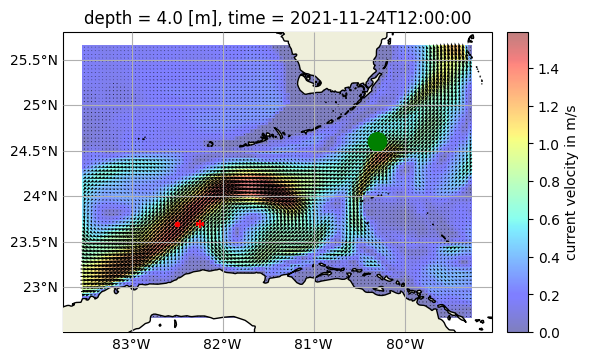

In [4]:
problem = NavigationProblem(
    start_state=x_set,
    end_region=x_T,
    target_radius=0.1,
    timeout=datetime.timedelta(days=2),
    platform_dict=arena.platform.platform_dict,
)

# # %% Plot the problem on the map
t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_set.to_spatio_temporal_point_set(), x_T=x_T, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)
ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
problem.plot(ax=ax)
plt.show()

In [5]:
specific_settings = {
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "backward",
    "n_time_vector": 200,
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box": 1.0,  # area over which to run HJ_reachability
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600 * 24 * 2,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "initial_set_radii": [
        0.1,
        0.1,
    ],  # this is in deg lat, lon. Note: for Backwards-Reachability this should be bigger.
    # Note: grid_res should always be bigger than initial_set_radii, otherwise reachability behaves weirdly.
    "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "d_max": 0.0,
    # 'EVM_threshold': 0.3 # in m/s error when floating in forecasted vs sensed currents
    # 'fwd_back_buffer_in_seconds': 0.5,  # this is the time added to the earliest_to_reach as buffer for forward-backward
    "platform_dict": arena.platform.platform_dict,
}
multi_agent_setting = {
    "planner": "hj_planner"
}
planner_set = MultiAgentPlanner(problem=problem, multi_agent_setting = multi_agent_setting, 
                                  specific_settings= specific_settings)

observation = arena.reset(platform_set=x_set)
#action = planner_set.get_action(observation=observation)

INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (5.4s)


In [5]:
update_rate_s = 60*120 #60 mins 
day_sim = 3
for i in tqdm(range(int(3600 * 24 * day_sim / update_rate_s))):  # 3 days
    action = planner_set.get_action(observation=observation)
    observation = arena.step(action)

arena.plot_all_on_map(problem=problem)

  0%|          | 0/24 [00:00<?, ?it/s]INFO:arena.controller:HJPlannerBase: Planning because of new forecast (Old: None, New: 0)
INFO:arena.controller:HJPlannerBase: Loading new Current Data (6.2s)
INFO:arena.controller:HJPlannerBase: Running backward
100%|##########|  1.0000/1.0 [00:00<00:00,  2.05sim_s/s]
INFO:arena.controller:HJPlannerBase: hj.solve finished (18.1s)
/anaconda/envs/ocean_minimal/lib/python3.9/site-packages/hj_reachability/dynamics.py:94: UserWarning:

x_init is not in the Backwards/Forwards Reachable Set/Tube

INFO:arena.controller:HJPlannerBase: Re-planning finished (68.9s)
INFO:arena.controller:HJPlannerBase: Planning because of new forecast (Old: None, New: 0)
INFO:arena.controller:HJPlannerBase: Loading new Current Data (5.7s)
INFO:arena.controller:HJPlannerBase: Running backward
100%|##########|  1.0000/1.0 [00:00<00:00,  2.61sim_s/s]
INFO:arena.controller:HJPlannerBase: hj.solve finished (10.1s)
/anaconda/envs/ocean_minimal/lib/python3.9/site-packages/hj_reachab

In [15]:
arena.state_trajectory.shape

(25, 2, 5)

In [25]:
arena.plot_all_on_map(problem = problem, show_control_trajectory=False, show_current_position=False)

IndexError: index 2 is out of bounds for axis 1 with size 2